<a href="https://colab.research.google.com/github/Maheshkumar293/Deforestation_Detection/blob/main/edu_net_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle torch torchvision segmentation-models-pytorch

In [ ]:
from google.colab import files
files.upload()   # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d apollo2506/eurosat-dataset
!unzip eurosat-dataset.zip -d dataset/


Streaming output truncated to the last 5000 lines.
  inflating: dataset/EuroSATallBands/River/River_1990.tif  
  inflating: dataset/EuroSATallBands/River/River_1991.tif  
  inflating: dataset/EuroSATallBands/River/River_1992.tif  
  inflating: dataset/EuroSATallBands/River/River_1993.tif  
  inflating: dataset/EuroSATallBands/River/River_1994.tif  
  inflating: dataset/EuroSATallBands/River/River_1995.tif  
  inflating: dataset/EuroSATallBands/River/River_1996.tif  
  inflating: dataset/EuroSATallBands/River/River_1997.tif  
  inflating: dataset/EuroSATallBands/River/River_1998.tif  
  inflating: dataset/EuroSATallBands/River/River_1999.tif  
  inflating: dataset/EuroSATallBands/River/River_2.tif  
  inflating: dataset/EuroSATallBands/River/River_20.tif  
  inflating: dataset/EuroSATallBands/River/River_200.tif  
  inflating: dataset/EuroSATallBands/River/River_2000.tif  
  inflating: dataset/EuroSATallBands/River/River_2001.tif  
  inflating: dataset/EuroSATallBands/River/River_2002.t

In [ ]:
# ==========================
# Multi-Class Land Cover Segmentation (EuroSAT)
# ==========================
import os, random
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms

# 1️⃣ Paths & Class Discovery
ROOT = "/content/dataset/EuroSAT"
classes = sorted([d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))])
print("Classes:", classes)

label_map = {cls: idx for idx, cls in enumerate(classes)}
print("Label Map:", label_map)

# Collect all images from all classes
all_imgs = []
for cls in classes:
    cls_path = os.path.join(ROOT, cls)
    imgs = glob(os.path.join(cls_path, "*.jpg"))
    all_imgs += [(p, label_map[cls]) for p in imgs]

random.shuffle(all_imgs)
split = int(0.85 * len(all_imgs))
train_list = all_imgs[:split]
val_list   = all_imgs[split:]

print(f"Total images: {len(all_imgs)} | Train: {len(train_list)} | Val: {len(val_list)}")

# 2️⃣ Dataset
class EuroSATSegDataset(Dataset):
    def __init__(self, items, img_size=128, transform=None):
        self.items = items
        self.img_size = img_size
        self.transform = transform or transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        mask = torch.full((self.img_size, self.img_size), fill_value=label, dtype=torch.long)
        return img, mask

# 3️⃣ Loaders
IMG_SIZE = 128
train_ds = EuroSATSegDataset(train_list, img_size=IMG_SIZE)
val_ds   = EuroSATSegDataset(val_list, img_size=IMG_SIZE)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

# 4️⃣ U-Net Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class SmallUNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.enc1 = DoubleConv(3, 32)
        self.enc2 = DoubleConv(32, 64)
        self.pool = nn.MaxPool2d(2)
        self.bott = DoubleConv(64, 128)
        self.up1  = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = DoubleConv(128, 64)
        self.up2  = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec2 = DoubleConv(64, 32)
        self.outc = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool(x1); x2 = self.enc2(x2)
        x3 = self.pool(x2); x3 = self.bott(x3)
        x = self.up1(x3); x = torch.cat([x, x2], dim=1); x = self.dec1(x)
        x = self.up2(x); x = torch.cat([x, x1], dim=1); x = self.dec2(x)
        return self.outc(x)

# 5️⃣ Train Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallUNet(n_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 6️⃣ Train Loop
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    tr_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Train {epoch+1}/{EPOCHS}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tr_loss += loss.item()
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            val_loss += criterion(model(imgs), masks).item()
    print(f"Epoch {epoch+1}/{EPOCHS}  TrainLoss: {tr_loss/len(train_loader):.4f}  ValLoss: {val_loss/len(val_loader):.4f}")

# 7️⃣ Save model
torch.save(model.state_dict(), "unet_eurosat_all.pth")
print("✅ Model saved as unet_eurosat_all.pth")

# 8️⃣ Inference
def infer_and_show(img_path, model, img_size=IMG_SIZE):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tf = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])
    t = tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(t)
        pred = out.argmax(dim=1).cpu().numpy()[0]
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Input"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(pred, cmap='tab20'); plt.title("Predicted Land Cover"); plt.axis('off')
    plt.show()


Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Label Map: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
Total images: 27000 | Train: 22950 | Val: 4050


Train 1/5: 100%|██████████| 2869/2869 [1:21:23<00:00,  1.70s/it]


Epoch 1/5  TrainLoss: 1.6690  ValLoss: 1.5444


Train 2/5: 100%|██████████| 2869/2869 [1:23:18<00:00,  1.74s/it]


Epoch 2/5  TrainLoss: 1.2923  ValLoss: 1.3320


Train 3/5: 100%|██████████| 2869/2869 [1:18:42<00:00,  1.65s/it]


Epoch 3/5  TrainLoss: 1.1455  ValLoss: 1.0850


Train 4/5: 100%|██████████| 2869/2869 [1:18:08<00:00,  1.63s/it]


Epoch 4/5  TrainLoss: 1.0643  ValLoss: 1.0165


Train 5/5: 100%|██████████| 2869/2869 [1:18:37<00:00,  1.64s/it]


Epoch 5/5  TrainLoss: 1.0102  ValLoss: 0.9896
✅ Model saved as unet_eurosat_all.pth


# run the trained model


In [ ]:
!pip install torch torchvision matplotlib pillow

✅ Model loaded successfully
Upload a satellite image:


Saving Residential_100.jpg to Residential_100.jpg


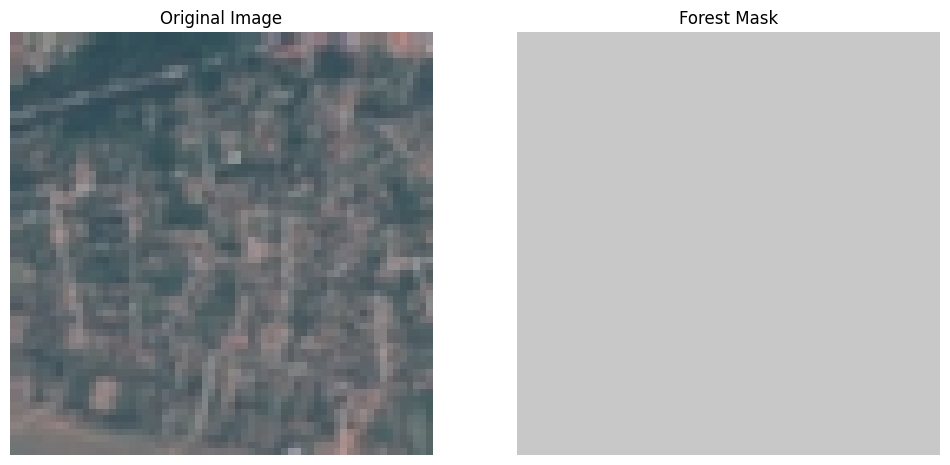

🌳 Forest Health Status: 🟥 Completely Deforested / No Forest
🌿 Forest Coverage: 0.00%


In [5]:
# ==========================
# 🌲 Forest Health Detector (Sliding Window)
# ==========================

!pip install torch torchvision matplotlib pillow

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from google.colab import files

# 1️⃣ U-Net definition (same as trained)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class SmallUNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.enc1 = DoubleConv(3, 32)
        self.enc2 = DoubleConv(32, 64)
        self.pool = nn.MaxPool2d(2)
        self.bott = DoubleConv(64, 128)
        self.up1  = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = DoubleConv(128, 64)
        self.up2  = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec2 = DoubleConv(64, 32)
        self.outc = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool(x1); x2 = self.enc2(x2)
        x3 = self.pool(x2); x3 = self.bott(x3)
        x = self.up1(x3); x = torch.cat([x, x2], dim=1); x = self.dec1(x)
        x = self.up2(x); x = torch.cat([x, x1], dim=1); x = self.dec2(x)
        return self.outc(x)

# 2️⃣ Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallUNet(n_classes=10).to(device)
model_path = "/content/unet_eurosat_all.pth"  # Upload your trained model
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("✅ Model loaded successfully")

# 3️⃣ Upload a single satellite image
print("Upload a satellite image:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
image_path = f"/content/{filename}"

# 4️⃣ Sliding window prediction
IMG_SIZE = 128
FOREST_CLASS = 1
OVERLAP = 0.5  # 50% overlap

def predict_large_image(image_path, model, img_size=IMG_SIZE, overlap=OVERLAP):
    img = Image.open(image_path).convert("RGB")
    width, height = img.size
    step = int(img_size * (1-overlap))

    # Initialize mask
    full_mask = np.zeros((height, width), dtype=np.uint8)
    count_mask = np.zeros((height, width), dtype=np.uint8)

    tf = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])

    for y in range(0, height, step):
        for x in range(0, width, step):
            # Crop patch
            x1, y1 = x, y
            x2, y2 = min(x+img_size, width), min(y+img_size, height)
            patch = img.crop((x1, y1, x2, y2))
            patch_tf = tf(patch).unsqueeze(0).to(device)

            with torch.no_grad():
                out = model(patch_tf)
                pred_patch = out.argmax(dim=1).cpu().numpy()[0]

            # Resize patch mask back to original patch size
            patch_mask = Image.fromarray(pred_patch.astype(np.uint8)).resize((x2-x1, y2-y1), Image.NEAREST)
            patch_mask = np.array(patch_mask, dtype=np.uint8)

            # Add to full mask
            full_mask[y1:y2, x1:x2] += patch_mask
            count_mask[y1:y2, x1:x2] += 1

    # Average overlapping regions
    full_mask = np.round(full_mask / count_mask).astype(np.uint8)
    return full_mask, img

# 5️⃣ Analyze forest health
def analyze_forest(full_mask, img, forest_class=FOREST_CLASS):
    forest_pixels = np.sum(full_mask == forest_class)
    total_pixels  = full_mask.size
    forest_percent = (forest_pixels / total_pixels) * 100

    if forest_percent == 0:
        status = "🟥 Completely Deforested / No Forest"
    elif forest_percent < 30:
        status = f"🟧 Partial Forest — {forest_percent:.2f}% coverage"
    else:
        status = f"🟩 Healthy Forest — {forest_percent:.2f}% coverage"

    # Greenish visualization
    mask_rgb = np.zeros((full_mask.shape[0], full_mask.shape[1], 3), dtype=np.uint8)
    mask_rgb[full_mask==FOREST_CLASS] = [34,139,34]  # forest = green
    mask_rgb[full_mask!=FOREST_CLASS] = [200,200,200]  # non-forest = gray

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original Image"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(mask_rgb); plt.title("Forest Mask"); plt.axis('off')
    plt.show()

    print("🌳 Forest Health Status:", status)
    print("🌿 Forest Coverage: {:.2f}%".format(forest_percent))

# 6️⃣ Run full prediction
mask, img = predict_large_image(image_path, model)
analyze_forest(mask, img)
